In [46]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import re
import sklearn
import seaborn as sns

sns.set_style('white')
sns.set_context('paper', font_scale=1.5)

plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['figure.titlesize'] = 32

In [47]:
print('numpy:', np.__version__)
print('pandas:', pd.__version__)
print('scikit-learn:', sklearn.__version__)
print('seaborn:', sns.__version__)

numpy: 1.13.0
pandas: 0.19.2
scikit-learn: 0.18.1
seaborn: 0.7.1


## Introducing Principal Component Analysis

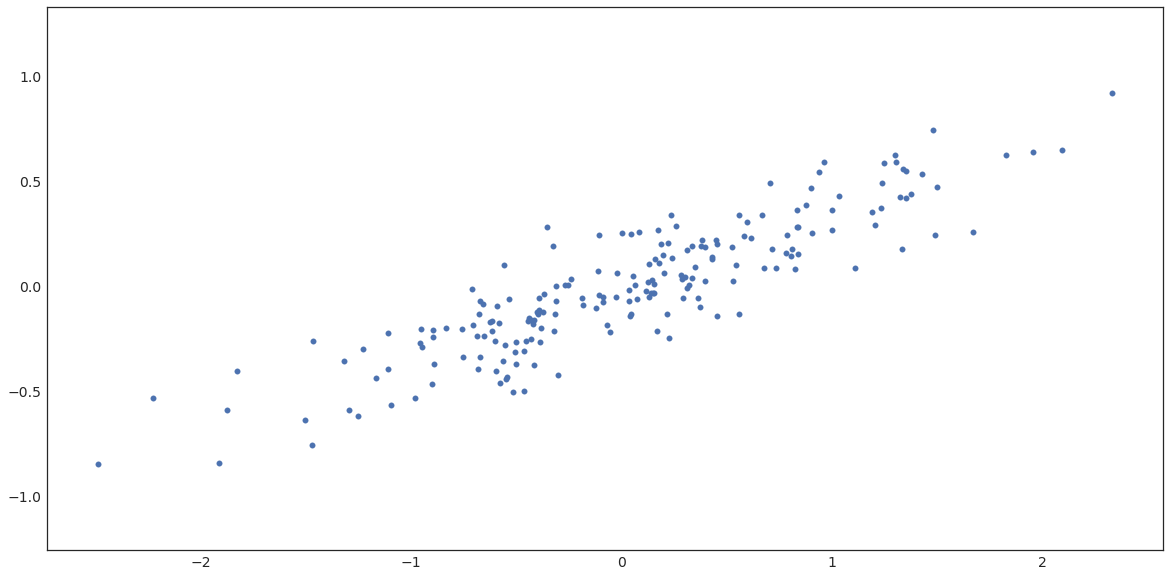

In [48]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');

By eye, it is clear that there is a nearly linear relationship between the x and y variables. This is reminiscent of the linear regression data, but the problem setting here is slightly different: rather than attempting to predict the y values from the x values, the unsupervised learning problem attempts to learn about the relationship between the x and y values.

In principal component analysis, this relationship is quantified by finding a list of the principal axes in the data, and using those axes to describe the dataset.

In [49]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [50]:
print(pca.components_)

[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]


In [51]:
print(pca.explained_variance_)

[ 0.75871884  0.01838551]


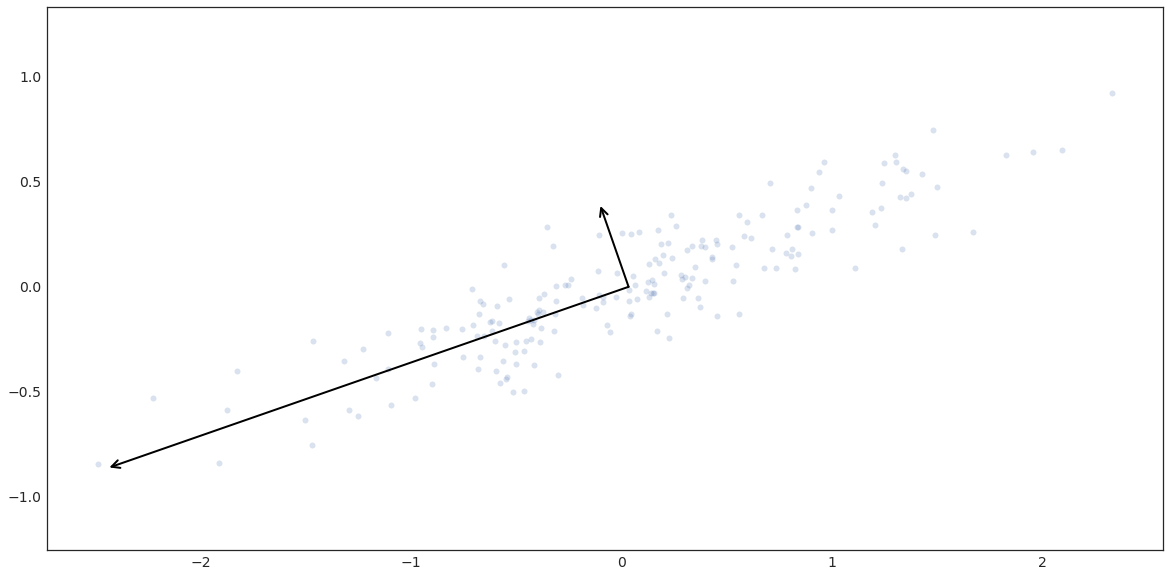

In [52]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

## Goal of Analysis

From the Seattle bike counter dataset, perpare a dataset that can be used for modeling:

* Understand the structure of the dataset through simple explorative charts
* Next perform a PCA analysis to see which of these columns could explain 95% of variance that is observed in our dataset.

![Fremont Bridge](https://upload.wikimedia.org/wikipedia/commons/a/ad/Fremont_Bridge-4.jpg)

In [53]:
!head fremont.csv

Date,Fremont Bridge West Sidewalk,Fremont Bridge East Sidewalk
10/03/2012 12:00:00 AM,4,9
10/03/2012 01:00:00 AM,4,6
10/03/2012 02:00:00 AM,1,1
10/03/2012 03:00:00 AM,2,3
10/03/2012 04:00:00 AM,6,1
10/03/2012 05:00:00 AM,21,10
10/03/2012 06:00:00 AM,105,50
10/03/2012 07:00:00 AM,257,95
10/03/2012 08:00:00 AM,291,146


In [54]:
data = pd.read_csv('fremont.csv', index_col='Date', parse_dates=True)
data.head()

,Fremont Bridge West Sidewalk,Fremont Bridge East Sidewalk
Date,,
2012-10-03 00:00:00,4.0,9.0
2012-10-03 01:00:00,4.0,6.0
2012-10-03 02:00:00,1.0,1.0
2012-10-03 03:00:00,2.0,3.0
2012-10-03 04:00:00,6.0,1.0


In [55]:
data.columns = ['West', 'East']

In [56]:
# create total bike rides
data['Total'] = data['West']  + data['East']

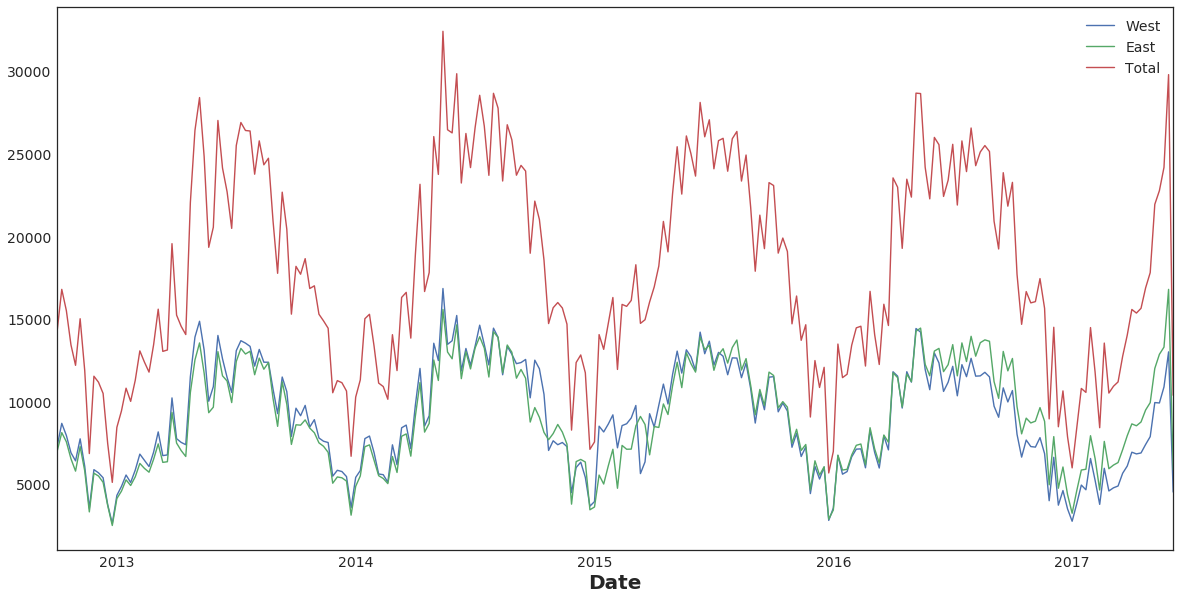

In [57]:
data.resample('W').sum().plot()

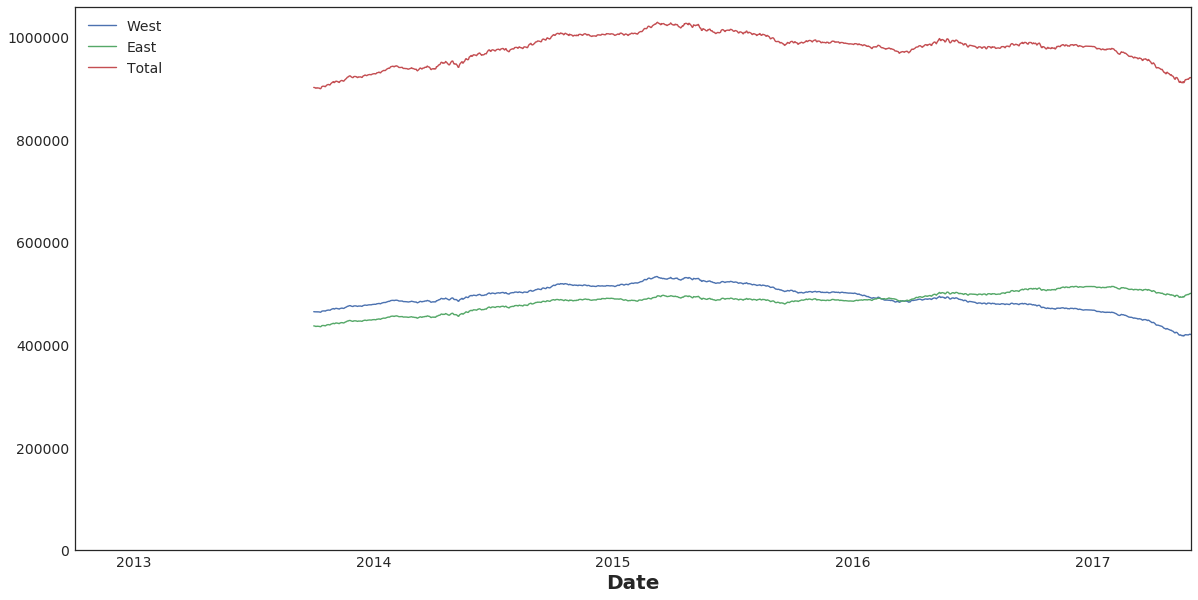

In [58]:
ax = data.resample('D').sum().rolling(365).sum().plot();
ax.set_ylim(0, None);

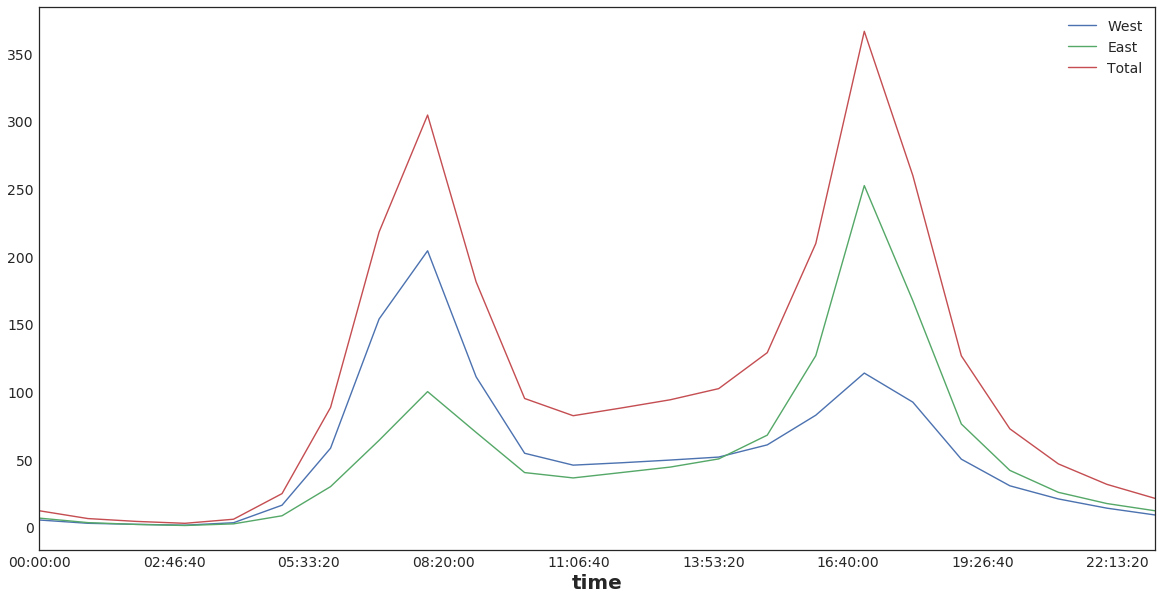

In [59]:
data.groupby(data.index.time).mean().plot();

In [60]:
pivoted = data.pivot_table('Total', index=data.index.time, columns=data.index.date)

pivoted.iloc[:5, :5]

,2012-10-03,2012-10-04,2012-10-05,2012-10-06,2012-10-07
00:00:00,13.0,18.0,11.0,15.0,11.0
01:00:00,10.0,3.0,8.0,15.0,17.0
02:00:00,2.0,9.0,7.0,9.0,3.0
03:00:00,5.0,3.0,4.0,3.0,6.0
04:00:00,7.0,8.0,9.0,5.0,3.0


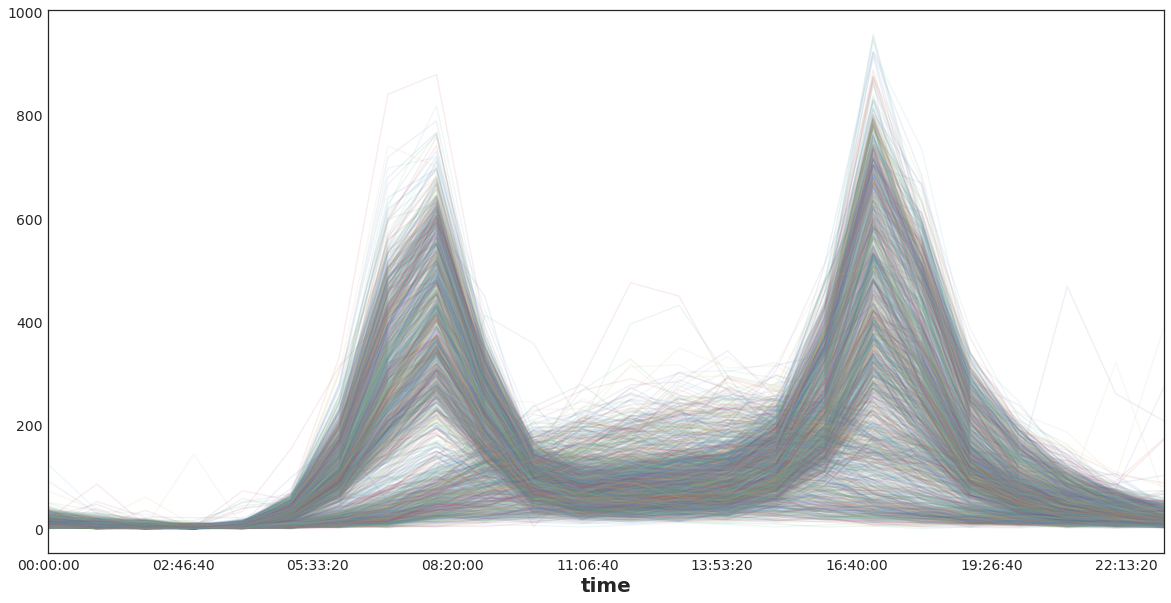

In [61]:
pivoted.plot(legend=False, alpha=0.1);

In [62]:
X = pivoted.fillna(0).T.values
X.shape

(1702, 24)

In [63]:
from sklearn.decomposition import PCA
pca = PCA(2, svd_solver='full').fit(X)
X2 = pca.transform(X)

In [64]:
pca.explained_variance_ratio_

array([ 0.8805659 ,  0.07580349])

In [65]:
X2.shape

(1702, 2)

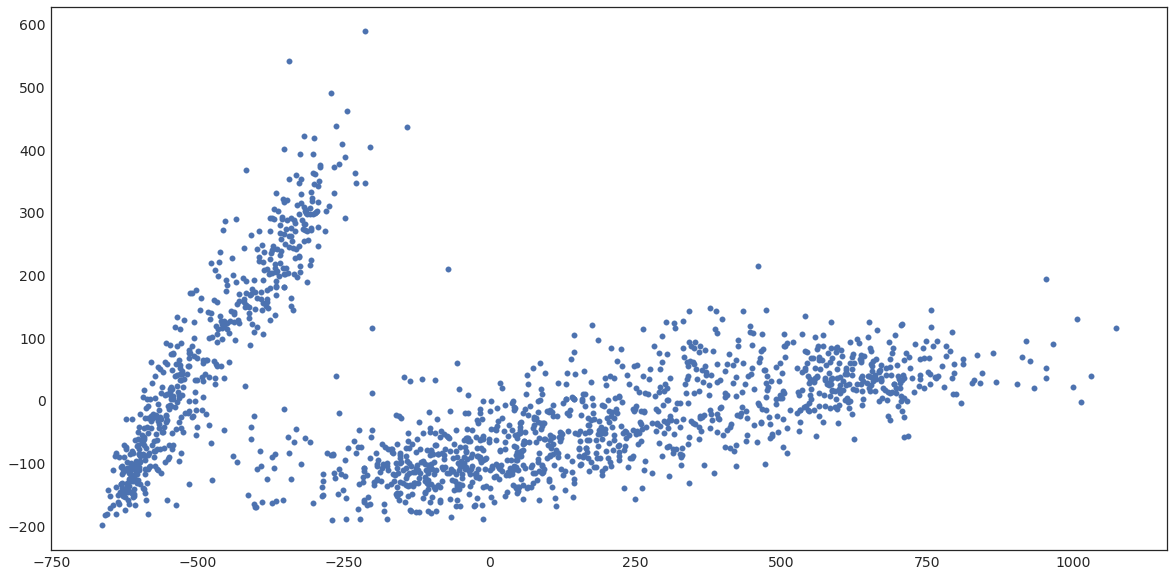

In [66]:
plt.scatter(X2[:, 0], X2[:, 1]);

In [67]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(2)

gmm.fit(X)

labels = gmm.predict(X)
labels

array([1, 1, 1, ..., 0, 1, 1])

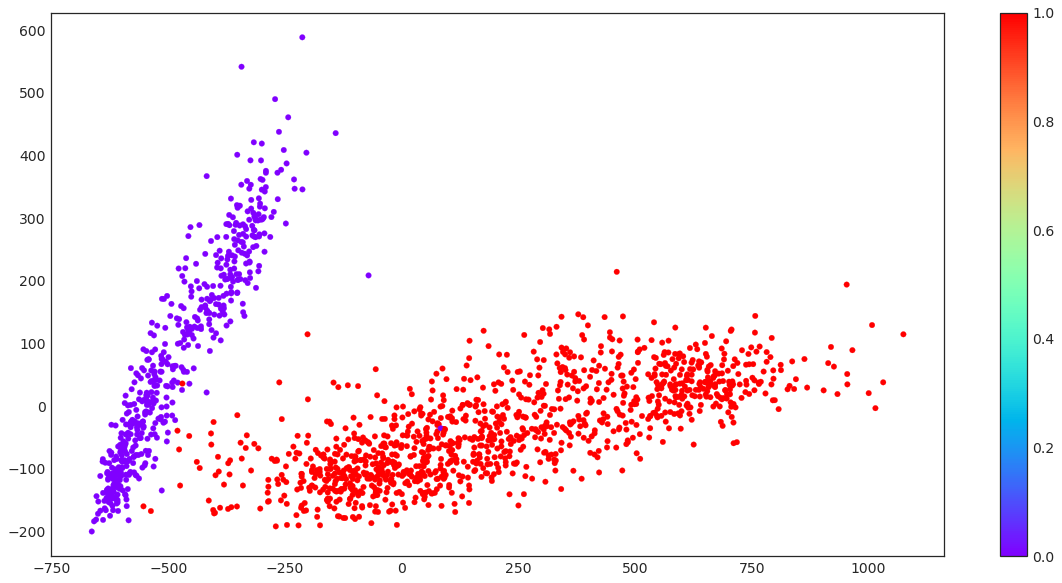

In [68]:
plt.scatter(X2[:, 0], X2[:, 1], c=labels, cmap='rainbow');
plt.colorbar();

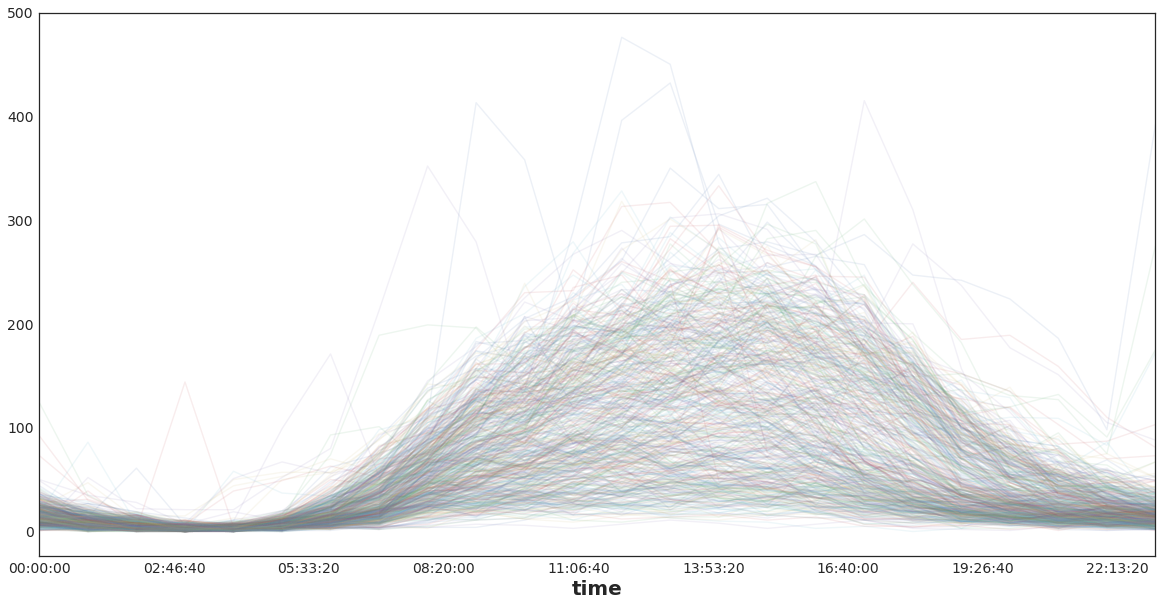

In [69]:
pivoted.T[labels == 0].T.plot(legend=False, alpha=0.1);

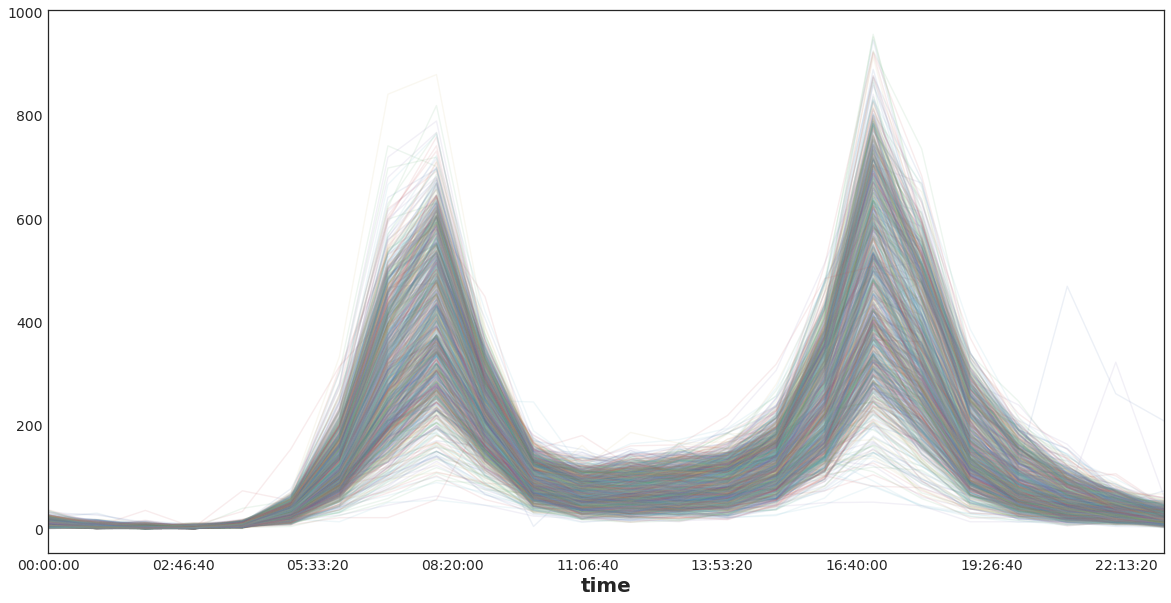

In [70]:
pivoted.T[labels == 1].T.plot(legend=False, alpha=0.1);

In [71]:
dayofweek = pd.DatetimeIndex(pivoted.columns).dayofweek

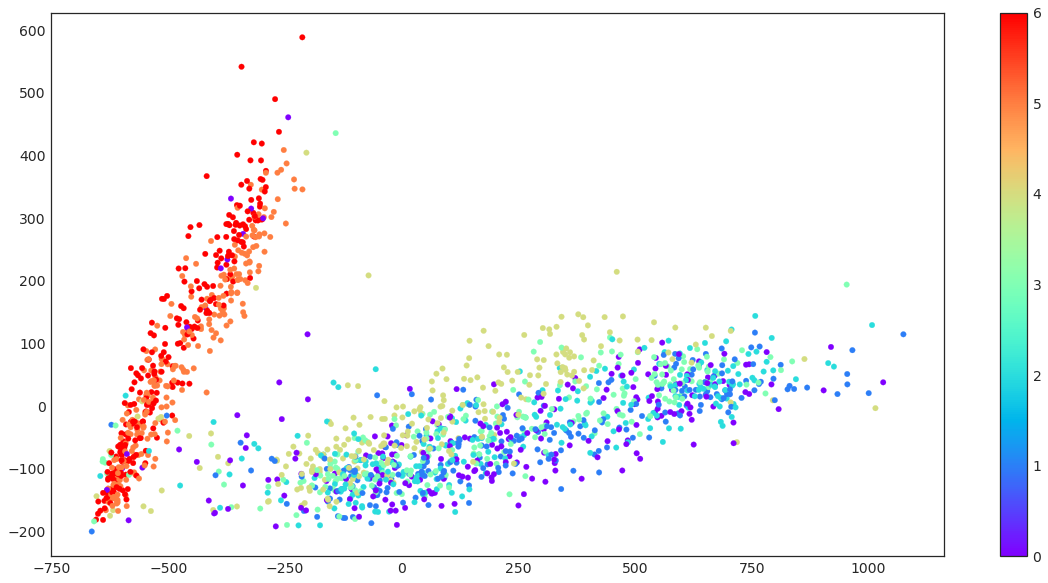

In [72]:
plt.scatter(X2[:, 0], X2[:, 1], c=dayofweek, cmap='rainbow');
plt.colorbar();

In [73]:
dates = pd.DatetimeIndex(pivoted.columns)
dates[(labels == 0) & (dayofweek < 5)]

DatetimeIndex(['2012-11-22', '2012-11-23', '2012-12-24', '2012-12-25',
               '2013-01-01', '2013-05-27', '2013-07-04', '2013-07-05',
               '2013-09-02', '2013-11-28', '2013-11-29', '2013-12-20',
               '2013-12-24', '2013-12-25', '2014-01-01', '2014-04-23',
               '2014-05-26', '2014-07-04', '2014-09-01', '2014-11-27',
               '2014-11-28', '2014-12-24', '2014-12-25', '2014-12-26',
               '2015-01-01', '2015-05-25', '2015-07-03', '2015-09-07',
               '2015-11-26', '2015-11-27', '2015-12-24', '2015-12-25',
               '2016-01-01', '2016-05-30', '2016-07-04', '2016-09-05',
               '2016-11-24', '2016-11-25', '2016-12-26', '2017-01-02',
               '2017-02-06', '2017-05-29'],
              dtype='datetime64[ns]', freq=None)